# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

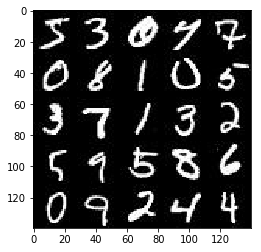

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

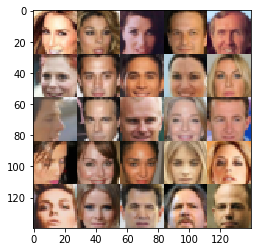

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.6.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input =  tf.placeholder(tf.float32,[None,image_width,image_height,image_channels])
    z_input = tf.placeholder(tf.float32,[None,z_dim])
    learning_rate = tf.placeholder(tf.float32)
    return (real_input,z_input,learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [63]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    keep_prob = 0.9
    with tf.variable_scope('discriminator',reuse=reuse):
        #28*28*16
        c1 = tf.layers.conv2d(images,16,kernel_size=5,strides=1,padding='same')
        lrel1 = tf.maximum(alpha*c1, c1)
        kp1 = tf.nn.dropout(lrel1,keep_prob=keep_prob)
        
        #14*14*32
        c2 = tf.layers.conv2d(kp1,32,kernel_size=5,strides=2,padding='same')
        bn1 = tf.layers.batch_normalization(c2,training=True)
        lrel2 = tf.maximum(alpha*bn1, bn1)
        kp2 = tf.nn.dropout(lrel2,keep_prob=keep_prob)
        
        #14*14*64
        c3 = tf.layers.conv2d(kp2,64,kernel_size=5,strides=1,padding='same')
        bn2 = tf.layers.batch_normalization(c3,training=True)
        lrel3 = tf.maximum(alpha*bn2, bn2)
        kp3 = tf.nn.dropout(lrel3,keep_prob=keep_prob)
        
        #7*7*128
        c4 = tf.layers.conv2d(kp3,128,kernel_size=5,strides=2,padding='same')
        bn3 = tf.layers.batch_normalization(c4,training=True)
        lrel4 = tf.maximum(alpha*bn3,bn3)
        kp4 = tf.nn.dropout(lrel4,keep_prob=keep_prob)
        
        #7*7*256
        c5 = tf.layers.conv2d(kp4,256,kernel_size=5,strides=1,padding='same')
        bn4 = tf.layers.batch_normalization(c5,training=True)
        lrel5 = tf.maximum(alpha*bn4,bn4)
        kp5 = tf.nn.dropout(lrel5,keep_prob=keep_prob)
        
        #4*4*512
        c6 = tf.layers.conv2d(kp5,512,kernel_size=4,strides=2,padding='same')
        bn5 = tf.layers.batch_normalization(c6,training=True)
        lrel6 = tf.maximum(alpha*bn5,bn5)
        kp6 = tf.nn.dropout(lrel6,keep_prob=keep_prob)
        
       
        #flattening 
        flat = tf.reshape(kp6,[-1,4*4*512])
        fc1 = tf.layers.dense(flat,1300)
        bn6 = tf.layers.batch_normalization(fc1,training=True)
        lrel7 = tf.maximum(alpha*bn6, bn6)
        kp7 = tf.nn.dropout(lrel7,keep_prob = keep_prob)
        
        #output
        logits = tf.layers.dense(kp7,1)
        out = tf.nn.sigmoid(logits)
    return (out,logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [64]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    keep_prob = 0.9
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse=not is_train):
        fc1 = tf.layers.dense(z,7*7*1024)
        
        #7*7*1024
        c1 = tf.reshape(fc1,[-1,7,7,1024])
        bn1 = tf.layers.batch_normalization(c1,training=is_train)
        lrel1 = tf.maximum(alpha*bn1 , bn1)
        
        #7*7*512
        c2 = tf.layers.conv2d_transpose(lrel1,512,kernel_size=5,strides=1,padding='same')
        bn2 = tf.layers.batch_normalization(c2,training=is_train)
        lrel2 = tf.maximum(alpha*bn2, bn2)
        kp1 = tf.nn.dropout(lrel2,keep_prob=keep_prob)
        
        #14*14*256
        c3 = tf.layers.conv2d_transpose(kp1,256,kernel_size=5,strides=2,padding='same')
        bn3 = tf.layers.batch_normalization(c3,training=is_train)
        lrel3 = tf.maximum(alpha*bn3,bn3)
        kp2 = tf.nn.dropout(lrel3,keep_prob=keep_prob)
        
        #14*14*128
        c4 = tf.layers.conv2d_transpose(kp2,128,kernel_size=5,strides=1,padding='same')
        bn4 = tf.layers.batch_normalization(c4,training=is_train)
        lrel4 = tf.maximum(alpha*bn4,bn4)
        kp3 = tf.nn.dropout(lrel4,keep_prob=keep_prob)
        
        #28*28*64
        c5 = tf.layers.conv2d_transpose(kp3,64,kernel_size=5,strides=2,padding='same')
        bn5 = tf.layers.batch_normalization(c5,training=is_train)
        lrel5 = tf.maximum(alpha*bn5,bn5)
        kp4 = tf.nn.dropout(lrel5,keep_prob=keep_prob)
        
        #28*28*3
        c6 = tf.layers.conv2d_transpose(kp4,out_channel_dim,kernel_size=5,strides=1,padding='same')
        out = tf.nn.tanh(c6)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [65]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z,out_channel_dim,is_train=True)
    d_model_real,d_model_real_logits = discriminator(input_real,reuse=False)
    d_model_fake,d_model_fake_logits = discriminator(g_model,reuse=True)
    

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_model_real_logits,
                                                                         labels=tf.ones_like(d_model_real_logits) *(1-smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_model_fake_logits,
                                                                        labels=tf.zeros_like(d_model_fake_logits)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_model_fake_logits,
                                                                   labels=tf.ones_like(d_model_fake_logits)))
    return (d_loss,g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [66]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(d_loss,var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(g_loss,var_list=g_vars)
    return d_opt,g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [67]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [85]:
import numpy as np
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _,image_width,image_height,image_channels = data_shape
    
    # getting placeholders
    input_real,input_z,lr = model_inputs(image_width,image_height,image_channels,z_dim)
    
    # getting losses
    d_loss,g_loss = model_loss(input_real,input_z,image_channels)
    
    # Getting optimizers
    d_opt,g_opt = model_opt(d_loss,g_loss,lr,beta1)
    
    step = 0
    
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1,1,(batch_size,z_dim))
                _ = sess.run(d_opt,feed_dict={input_real:batch_images,
                                             input_z:batch_z,
                                             lr:learning_rate})
                
                _ = sess.run(g_opt,feed_dict={input_real:batch_images,
                                             input_z:batch_z,
                                             lr:learning_rate})
                
                if step == 1:
                    print('initial output')
                    show_generator_output(sess,25,input_z,image_channels,data_image_mode)
                if step % 10 == 0:
                    train_loss_d = sess.run(d_loss,feed_dict={input_real:batch_images,
                                                    input_z:batch_z,
                                                    lr:learning_rate})
                    train_loss_g = sess.run(g_loss,feed_dict={input_real:batch_images,
                                                    input_z:batch_z,
                                                    lr:learning_rate})
                    print('Epochs {},batches {}, dis_loss {} , gen_loss {}'.format(epoch_i+1,step,train_loss_d,train_loss_g))
                if step%100 == 0:
                    show_generator_output(sess,25,input_z,image_channels,data_image_mode)
        saver.save(sess, './generator.ckpt')

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

initial output


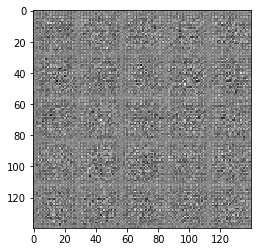

Epochs 1,batches 10, dis_loss 1.5702996253967285 , gen_loss 0.9314091801643372
Epochs 1,batches 20, dis_loss 1.5241343975067139 , gen_loss 0.8954910635948181
Epochs 1,batches 30, dis_loss 1.540128231048584 , gen_loss 0.9556760787963867
Epochs 1,batches 40, dis_loss 1.5539190769195557 , gen_loss 0.9368438124656677
Epochs 1,batches 50, dis_loss 1.5904099941253662 , gen_loss 0.967535674571991
Epochs 1,batches 60, dis_loss 1.6715242862701416 , gen_loss 0.9139390587806702
Epochs 1,batches 70, dis_loss 1.676450252532959 , gen_loss 0.8869394659996033
Epochs 1,batches 80, dis_loss 1.5133652687072754 , gen_loss 0.9295114874839783
Epochs 1,batches 90, dis_loss 1.4911372661590576 , gen_loss 0.9102417230606079
Epochs 1,batches 100, dis_loss 1.5368632078170776 , gen_loss 0.9252001643180847


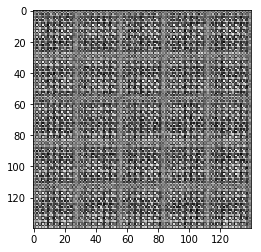

Epochs 1,batches 110, dis_loss 1.4952731132507324 , gen_loss 0.9236927032470703
Epochs 1,batches 120, dis_loss 1.5559172630310059 , gen_loss 0.8543116450309753
Epochs 1,batches 130, dis_loss 1.5589239597320557 , gen_loss 0.8957670331001282
Epochs 1,batches 140, dis_loss 1.4761996269226074 , gen_loss 0.9083866477012634
Epochs 1,batches 150, dis_loss 1.4342107772827148 , gen_loss 0.9103168249130249
Epochs 1,batches 160, dis_loss 1.5207393169403076 , gen_loss 0.8802280426025391
Epochs 1,batches 170, dis_loss 1.4558308124542236 , gen_loss 0.8818786144256592
Epochs 1,batches 180, dis_loss 1.4641566276550293 , gen_loss 0.8965181708335876
Epochs 1,batches 190, dis_loss 1.5766708850860596 , gen_loss 0.8260813355445862
Epochs 1,batches 200, dis_loss 1.5703108310699463 , gen_loss 0.8418297171592712


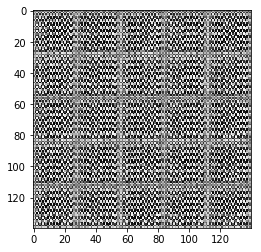

Epochs 1,batches 210, dis_loss 1.4839885234832764 , gen_loss 0.8638113737106323
Epochs 1,batches 220, dis_loss 1.4846712350845337 , gen_loss 0.8085688948631287
Epochs 1,batches 230, dis_loss 1.4993250370025635 , gen_loss 0.8558000922203064
Epochs 1,batches 240, dis_loss 1.4996800422668457 , gen_loss 0.8525969386100769
Epochs 1,batches 250, dis_loss 1.4015029668807983 , gen_loss 0.8888939023017883
Epochs 1,batches 260, dis_loss 1.4849269390106201 , gen_loss 0.8774411678314209
Epochs 1,batches 270, dis_loss 1.426095962524414 , gen_loss 0.9568483829498291
Epochs 1,batches 280, dis_loss 1.4472877979278564 , gen_loss 0.8396672010421753
Epochs 1,batches 290, dis_loss 1.4756014347076416 , gen_loss 0.8131541013717651
Epochs 1,batches 300, dis_loss 1.4542149305343628 , gen_loss 0.9499983191490173


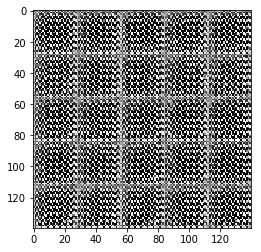

Epochs 1,batches 310, dis_loss 1.4789924621582031 , gen_loss 0.8615699410438538
Epochs 1,batches 320, dis_loss 1.4347909688949585 , gen_loss 0.890049397945404
Epochs 1,batches 330, dis_loss 1.5230716466903687 , gen_loss 0.8971399664878845
Epochs 1,batches 340, dis_loss 1.4847424030303955 , gen_loss 0.8779058456420898
Epochs 1,batches 350, dis_loss 1.4669010639190674 , gen_loss 0.8943197727203369
Epochs 1,batches 360, dis_loss 1.4062035083770752 , gen_loss 0.9147250652313232
Epochs 1,batches 370, dis_loss 1.4492559432983398 , gen_loss 0.8935412764549255
Epochs 1,batches 380, dis_loss 1.3906432390213013 , gen_loss 0.9340706467628479
Epochs 1,batches 390, dis_loss 1.4131381511688232 , gen_loss 0.9381637573242188
Epochs 1,batches 400, dis_loss 1.432040810585022 , gen_loss 0.9000116586685181


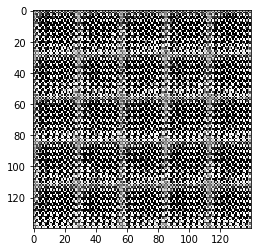

Epochs 1,batches 410, dis_loss 1.4071097373962402 , gen_loss 1.0145014524459839
Epochs 1,batches 420, dis_loss 1.400792121887207 , gen_loss 0.8962146043777466
Epochs 1,batches 430, dis_loss 1.429985761642456 , gen_loss 0.9068242311477661
Epochs 1,batches 440, dis_loss 1.3926024436950684 , gen_loss 0.9245869517326355
Epochs 1,batches 450, dis_loss 1.3561389446258545 , gen_loss 0.9332358241081238
Epochs 1,batches 460, dis_loss 1.368408203125 , gen_loss 0.965158224105835
Epochs 1,batches 470, dis_loss 1.3700368404388428 , gen_loss 0.9538217186927795
Epochs 1,batches 480, dis_loss 1.2386105060577393 , gen_loss 0.955731987953186
Epochs 1,batches 490, dis_loss 1.2891390323638916 , gen_loss 0.9806803464889526
Epochs 1,batches 500, dis_loss 1.2656855583190918 , gen_loss 1.0156363248825073


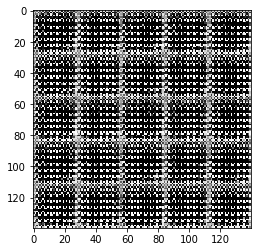

Epochs 1,batches 510, dis_loss 1.3458207845687866 , gen_loss 1.0067954063415527
Epochs 1,batches 520, dis_loss 1.3985453844070435 , gen_loss 0.9826080203056335
Epochs 1,batches 530, dis_loss 1.396724820137024 , gen_loss 1.0333106517791748
Epochs 1,batches 540, dis_loss 1.2751526832580566 , gen_loss 0.9374138712882996
Epochs 1,batches 550, dis_loss 1.2529606819152832 , gen_loss 1.0322397947311401
Epochs 1,batches 560, dis_loss 1.2728049755096436 , gen_loss 1.0188452005386353
Epochs 1,batches 570, dis_loss 1.2665139436721802 , gen_loss 1.0112673044204712
Epochs 1,batches 580, dis_loss 1.31877863407135 , gen_loss 1.0529780387878418
Epochs 1,batches 590, dis_loss 1.296736240386963 , gen_loss 1.0108110904693604
Epochs 1,batches 600, dis_loss 1.267749309539795 , gen_loss 1.138171672821045


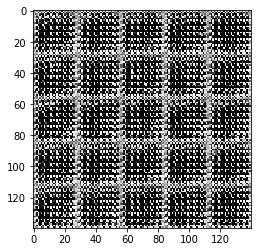

Epochs 1,batches 610, dis_loss 1.2927266359329224 , gen_loss 1.0663259029388428
Epochs 1,batches 620, dis_loss 1.2269551753997803 , gen_loss 1.0870215892791748
Epochs 1,batches 630, dis_loss 1.106776475906372 , gen_loss 1.1465622186660767
Epochs 1,batches 640, dis_loss 1.117035150527954 , gen_loss 1.165824055671692
Epochs 1,batches 650, dis_loss 1.2074172496795654 , gen_loss 1.057404637336731
Epochs 1,batches 660, dis_loss 1.1909334659576416 , gen_loss 1.0998806953430176
Epochs 1,batches 670, dis_loss 0.9698096513748169 , gen_loss 1.3361042737960815
Epochs 1,batches 680, dis_loss 1.3946762084960938 , gen_loss 1.2099629640579224
Epochs 1,batches 690, dis_loss 0.974820613861084 , gen_loss 1.3094617128372192
Epochs 1,batches 700, dis_loss 1.0804256200790405 , gen_loss 1.1888259649276733


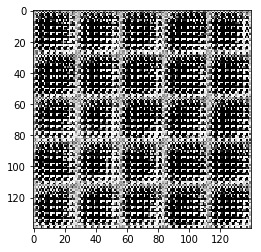

Epochs 1,batches 710, dis_loss 1.1002061367034912 , gen_loss 0.9546099901199341
Epochs 1,batches 720, dis_loss 1.0688612461090088 , gen_loss 0.9985048770904541
Epochs 1,batches 730, dis_loss 1.1310069561004639 , gen_loss 1.0397740602493286
Epochs 1,batches 740, dis_loss 1.151503324508667 , gen_loss 1.0414879322052002
Epochs 1,batches 750, dis_loss 1.1992974281311035 , gen_loss 0.983016312122345
Epochs 1,batches 760, dis_loss 1.8332884311676025 , gen_loss 0.7705921530723572
Epochs 1,batches 770, dis_loss 1.2444789409637451 , gen_loss 0.6914895176887512
Epochs 1,batches 780, dis_loss 1.2718784809112549 , gen_loss 0.9114706516265869
Epochs 1,batches 790, dis_loss 1.2033381462097168 , gen_loss 0.9136644005775452
Epochs 1,batches 800, dis_loss 1.1318325996398926 , gen_loss 0.9108439087867737


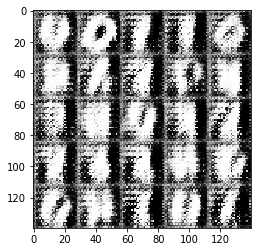

Epochs 1,batches 810, dis_loss 1.3170254230499268 , gen_loss 0.87445068359375
Epochs 1,batches 820, dis_loss 1.4658570289611816 , gen_loss 0.7358614206314087
Epochs 1,batches 830, dis_loss 1.4470281600952148 , gen_loss 0.8037883043289185
Epochs 1,batches 840, dis_loss 1.4599595069885254 , gen_loss 0.7246879935264587
Epochs 1,batches 850, dis_loss 1.3591700792312622 , gen_loss 0.7746316194534302
Epochs 1,batches 860, dis_loss 1.3071951866149902 , gen_loss 0.7797346115112305
Epochs 1,batches 870, dis_loss 1.4239546060562134 , gen_loss 0.7693362832069397
Epochs 1,batches 880, dis_loss 1.3349199295043945 , gen_loss 0.8145304322242737
Epochs 1,batches 890, dis_loss 1.276822566986084 , gen_loss 0.8569613099098206
Epochs 1,batches 900, dis_loss 1.3934404850006104 , gen_loss 0.8578363656997681


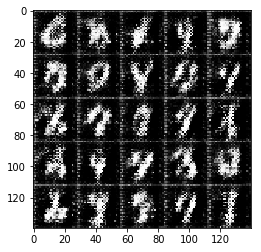

Epochs 1,batches 910, dis_loss 1.5836431980133057 , gen_loss 0.6771096587181091
Epochs 1,batches 920, dis_loss 1.522256851196289 , gen_loss 0.7307147979736328
Epochs 1,batches 930, dis_loss 1.3196229934692383 , gen_loss 0.7701399922370911
Epochs 1,batches 940, dis_loss 1.370021939277649 , gen_loss 0.889083206653595
Epochs 1,batches 950, dis_loss 1.3694024085998535 , gen_loss 0.8066059947013855
Epochs 1,batches 960, dis_loss 1.283714771270752 , gen_loss 0.8821509480476379
Epochs 1,batches 970, dis_loss 1.324644923210144 , gen_loss 0.8198683261871338
Epochs 1,batches 980, dis_loss 1.4030938148498535 , gen_loss 0.6758140921592712
Epochs 1,batches 990, dis_loss 1.3614928722381592 , gen_loss 0.8475080132484436
Epochs 1,batches 1000, dis_loss 1.3085401058197021 , gen_loss 0.8019677400588989


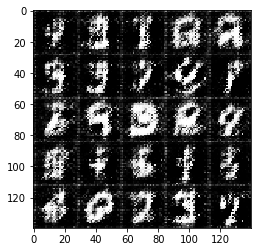

Epochs 1,batches 1010, dis_loss 1.299668788909912 , gen_loss 0.9118561148643494
Epochs 1,batches 1020, dis_loss 1.4465551376342773 , gen_loss 0.7080907225608826
Epochs 1,batches 1030, dis_loss 1.2329320907592773 , gen_loss 0.9209377765655518
Epochs 1,batches 1040, dis_loss 1.3556807041168213 , gen_loss 0.7685877680778503
Epochs 1,batches 1050, dis_loss 1.4667888879776 , gen_loss 0.7958755493164062
Epochs 1,batches 1060, dis_loss 1.337709665298462 , gen_loss 0.7596511244773865
Epochs 1,batches 1070, dis_loss 1.442122459411621 , gen_loss 0.8384678959846497
Epochs 1,batches 1080, dis_loss 1.2338005304336548 , gen_loss 0.7647138833999634
Epochs 1,batches 1090, dis_loss 1.3564074039459229 , gen_loss 0.8126220703125
Epochs 1,batches 1100, dis_loss 1.585157871246338 , gen_loss 0.7464768290519714


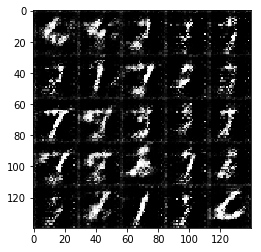

Epochs 1,batches 1110, dis_loss 1.3784308433532715 , gen_loss 0.8063520789146423
Epochs 1,batches 1120, dis_loss 1.4416840076446533 , gen_loss 0.7337411642074585
Epochs 1,batches 1130, dis_loss 1.4103167057037354 , gen_loss 0.8480609655380249
Epochs 1,batches 1140, dis_loss 1.234418272972107 , gen_loss 0.8291464447975159
Epochs 1,batches 1150, dis_loss 1.4264601469039917 , gen_loss 0.7543532848358154
Epochs 1,batches 1160, dis_loss 1.3263399600982666 , gen_loss 0.8093985319137573
Epochs 1,batches 1170, dis_loss 1.4297059774398804 , gen_loss 0.7818392515182495
Epochs 1,batches 1180, dis_loss 1.2898313999176025 , gen_loss 0.858253538608551
Epochs 1,batches 1190, dis_loss 1.2996301651000977 , gen_loss 0.8092110753059387
Epochs 1,batches 1200, dis_loss 1.3592610359191895 , gen_loss 0.7929596304893494


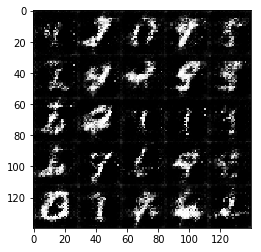

Epochs 1,batches 1210, dis_loss 1.3063006401062012 , gen_loss 0.827246367931366
Epochs 1,batches 1220, dis_loss 1.4334428310394287 , gen_loss 0.8485908508300781
Epochs 1,batches 1230, dis_loss 1.4308083057403564 , gen_loss 0.7604013085365295
Epochs 1,batches 1240, dis_loss 1.4527952671051025 , gen_loss 0.7148309350013733
Epochs 1,batches 1250, dis_loss 1.4055159091949463 , gen_loss 0.8129689693450928
Epochs 1,batches 1260, dis_loss 1.456414818763733 , gen_loss 0.736642599105835
Epochs 1,batches 1270, dis_loss 1.439562201499939 , gen_loss 0.770731508731842
Epochs 1,batches 1280, dis_loss 1.3390107154846191 , gen_loss 0.8509078621864319
Epochs 1,batches 1290, dis_loss 1.3145768642425537 , gen_loss 0.890168309211731
Epochs 1,batches 1300, dis_loss 1.3634278774261475 , gen_loss 0.7277902364730835


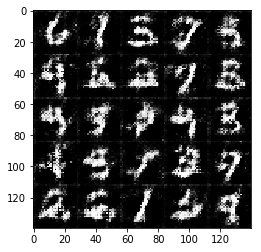

Epochs 1,batches 1310, dis_loss 1.3900058269500732 , gen_loss 0.6897287964820862
Epochs 1,batches 1320, dis_loss 1.4257432222366333 , gen_loss 0.8077291250228882
Epochs 1,batches 1330, dis_loss 1.346519947052002 , gen_loss 0.8069143295288086
Epochs 1,batches 1340, dis_loss 1.3217047452926636 , gen_loss 0.8594226837158203
Epochs 1,batches 1350, dis_loss 1.4680407047271729 , gen_loss 0.7952288389205933
Epochs 1,batches 1360, dis_loss 1.279918909072876 , gen_loss 0.7673856019973755
Epochs 1,batches 1370, dis_loss 1.4081158638000488 , gen_loss 0.8101403713226318
Epochs 1,batches 1380, dis_loss 1.3908488750457764 , gen_loss 0.8880123496055603
Epochs 1,batches 1390, dis_loss 1.3689082860946655 , gen_loss 0.7689656615257263
Epochs 1,batches 1400, dis_loss 1.406317949295044 , gen_loss 0.8044934868812561


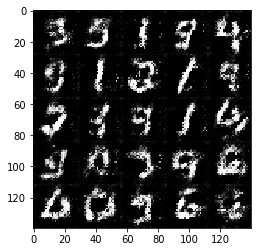

Epochs 1,batches 1410, dis_loss 1.3491041660308838 , gen_loss 0.8147374987602234
Epochs 1,batches 1420, dis_loss 1.377316951751709 , gen_loss 0.8018500208854675
Epochs 1,batches 1430, dis_loss 1.2590254545211792 , gen_loss 0.8251171708106995
Epochs 1,batches 1440, dis_loss 1.31460702419281 , gen_loss 0.809556782245636
Epochs 1,batches 1450, dis_loss 1.3845758438110352 , gen_loss 0.8756912350654602
Epochs 1,batches 1460, dis_loss 1.3278748989105225 , gen_loss 0.794070303440094
Epochs 1,batches 1470, dis_loss 1.3637208938598633 , gen_loss 0.843512237071991
Epochs 1,batches 1480, dis_loss 1.4493536949157715 , gen_loss 0.8912175893783569
Epochs 1,batches 1490, dis_loss 1.3270765542984009 , gen_loss 0.8502942323684692
Epochs 1,batches 1500, dis_loss 1.4634783267974854 , gen_loss 0.7512312531471252


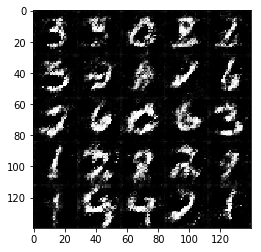

Epochs 1,batches 1510, dis_loss 1.4080030918121338 , gen_loss 0.8219395279884338
Epochs 1,batches 1520, dis_loss 1.264338493347168 , gen_loss 0.8146750330924988
Epochs 1,batches 1530, dis_loss 1.4044665098190308 , gen_loss 0.8088113069534302
Epochs 1,batches 1540, dis_loss 1.241945743560791 , gen_loss 0.8675734400749207
Epochs 1,batches 1550, dis_loss 1.4073987007141113 , gen_loss 0.8693884611129761
Epochs 1,batches 1560, dis_loss 1.4240658283233643 , gen_loss 0.8135045170783997
Epochs 1,batches 1570, dis_loss 1.4251881837844849 , gen_loss 0.889697790145874
Epochs 1,batches 1580, dis_loss 1.3780474662780762 , gen_loss 0.8278063535690308
Epochs 1,batches 1590, dis_loss 1.2801029682159424 , gen_loss 0.8866590857505798
Epochs 1,batches 1600, dis_loss 1.485377311706543 , gen_loss 0.7536903619766235


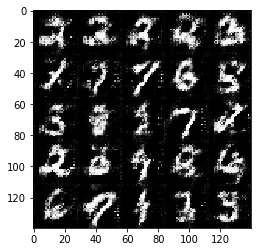

Epochs 1,batches 1610, dis_loss 1.276139736175537 , gen_loss 0.905981719493866
Epochs 1,batches 1620, dis_loss 1.2546180486679077 , gen_loss 0.7901264429092407
Epochs 1,batches 1630, dis_loss 1.4214763641357422 , gen_loss 0.8109331727027893
Epochs 1,batches 1640, dis_loss 1.38833749294281 , gen_loss 0.7765305638313293
Epochs 1,batches 1650, dis_loss 1.3821425437927246 , gen_loss 0.8448060154914856
Epochs 1,batches 1660, dis_loss 1.3615989685058594 , gen_loss 0.8337411284446716
Epochs 1,batches 1670, dis_loss 1.406337022781372 , gen_loss 0.7223762273788452
Epochs 1,batches 1680, dis_loss 1.358776569366455 , gen_loss 0.860401451587677
Epochs 1,batches 1690, dis_loss 1.3459713459014893 , gen_loss 0.8681040406227112
Epochs 1,batches 1700, dis_loss 1.4707651138305664 , gen_loss 0.6836847066879272


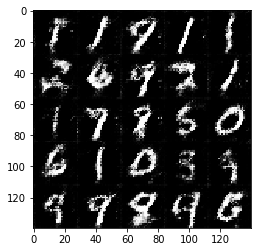

Epochs 1,batches 1710, dis_loss 1.4010136127471924 , gen_loss 0.825939416885376
Epochs 1,batches 1720, dis_loss 1.3722083568572998 , gen_loss 0.7636021375656128
Epochs 1,batches 1730, dis_loss 1.3073132038116455 , gen_loss 0.8291550874710083
Epochs 1,batches 1740, dis_loss 1.227818250656128 , gen_loss 0.8855596780776978
Epochs 1,batches 1750, dis_loss 1.324733018875122 , gen_loss 0.8713861107826233
Epochs 1,batches 1760, dis_loss 1.323670506477356 , gen_loss 0.8330552577972412
Epochs 1,batches 1770, dis_loss 1.3637484312057495 , gen_loss 0.8436214327812195
Epochs 1,batches 1780, dis_loss 1.312288522720337 , gen_loss 0.8440688848495483
Epochs 1,batches 1790, dis_loss 1.372432827949524 , gen_loss 0.7822797298431396
Epochs 1,batches 1800, dis_loss 1.424830436706543 , gen_loss 0.7892382740974426


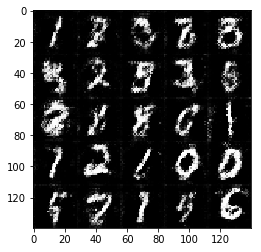

Epochs 1,batches 1810, dis_loss 1.4160655736923218 , gen_loss 0.7756790518760681
Epochs 1,batches 1820, dis_loss 1.3524378538131714 , gen_loss 0.7616241574287415
Epochs 1,batches 1830, dis_loss 1.5095689296722412 , gen_loss 0.7897204756736755
Epochs 1,batches 1840, dis_loss 1.4430429935455322 , gen_loss 0.741468071937561
Epochs 1,batches 1850, dis_loss 1.3494653701782227 , gen_loss 0.800281822681427
Epochs 1,batches 1860, dis_loss 1.2485606670379639 , gen_loss 0.8886896371841431
Epochs 1,batches 1870, dis_loss 1.426573634147644 , gen_loss 0.7440125942230225
Epochs 1,batches 1880, dis_loss 1.3761298656463623 , gen_loss 0.8303301930427551
Epochs 1,batches 1890, dis_loss 1.379852056503296 , gen_loss 0.7556238770484924
Epochs 1,batches 1900, dis_loss 1.319378137588501 , gen_loss 0.8129683136940002


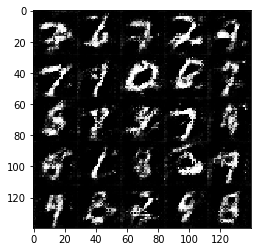

Epochs 1,batches 1910, dis_loss 1.3456345796585083 , gen_loss 0.7998476624488831
Epochs 1,batches 1920, dis_loss 1.3529930114746094 , gen_loss 0.7728734612464905
Epochs 1,batches 1930, dis_loss 1.3980863094329834 , gen_loss 0.8033500909805298
Epochs 1,batches 1940, dis_loss 1.3541897535324097 , gen_loss 0.7547672390937805
Epochs 1,batches 1950, dis_loss 1.2780177593231201 , gen_loss 0.8653849959373474
Epochs 1,batches 1960, dis_loss 1.39682936668396 , gen_loss 0.7925930023193359
Epochs 1,batches 1970, dis_loss 1.2282510995864868 , gen_loss 0.9562273621559143
Epochs 1,batches 1980, dis_loss 1.4781420230865479 , gen_loss 0.8404767513275146
Epochs 1,batches 1990, dis_loss 1.4027659893035889 , gen_loss 0.8032913208007812
Epochs 1,batches 2000, dis_loss 1.384485125541687 , gen_loss 0.8318793177604675


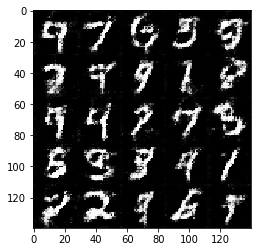

Epochs 2,batches 2010, dis_loss 1.4706279039382935 , gen_loss 0.7700429558753967
Epochs 2,batches 2020, dis_loss 1.2841887474060059 , gen_loss 0.888830840587616
Epochs 2,batches 2030, dis_loss 1.2906849384307861 , gen_loss 0.803460955619812
Epochs 2,batches 2040, dis_loss 1.3540581464767456 , gen_loss 0.821871817111969
Epochs 2,batches 2050, dis_loss 1.291205883026123 , gen_loss 0.793824315071106
Epochs 2,batches 2060, dis_loss 1.4810106754302979 , gen_loss 0.732383131980896
Epochs 2,batches 2070, dis_loss 1.4725000858306885 , gen_loss 0.811797559261322
Epochs 2,batches 2080, dis_loss 1.3330981731414795 , gen_loss 0.851596474647522
Epochs 2,batches 2090, dis_loss 1.2685127258300781 , gen_loss 0.8728231191635132
Epochs 2,batches 2100, dis_loss 1.3279701471328735 , gen_loss 0.8408076167106628


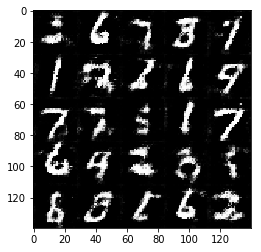

Epochs 2,batches 2110, dis_loss 1.4007784128189087 , gen_loss 0.78763747215271
Epochs 2,batches 2120, dis_loss 1.425924301147461 , gen_loss 0.7603127956390381
Epochs 2,batches 2130, dis_loss 1.414058804512024 , gen_loss 0.7689347863197327
Epochs 2,batches 2140, dis_loss 1.4754503965377808 , gen_loss 0.7800495624542236
Epochs 2,batches 2150, dis_loss 1.3063302040100098 , gen_loss 0.8501895070075989
Epochs 2,batches 2160, dis_loss 1.4423980712890625 , gen_loss 0.7747824192047119
Epochs 2,batches 2170, dis_loss 1.4515833854675293 , gen_loss 0.7277601361274719
Epochs 2,batches 2180, dis_loss 1.4293391704559326 , gen_loss 0.8315298557281494
Epochs 2,batches 2190, dis_loss 1.392579197883606 , gen_loss 0.8084198832511902
Epochs 2,batches 2200, dis_loss 1.273835301399231 , gen_loss 0.9377297759056091


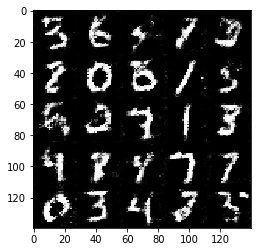

Epochs 2,batches 2210, dis_loss 1.2854807376861572 , gen_loss 0.9349450469017029
Epochs 2,batches 2220, dis_loss 1.2907097339630127 , gen_loss 0.9035883545875549
Epochs 2,batches 2230, dis_loss 1.5163791179656982 , gen_loss 0.7266603112220764
Epochs 2,batches 2240, dis_loss 1.3662691116333008 , gen_loss 0.8290138840675354
Epochs 2,batches 2250, dis_loss 1.3216581344604492 , gen_loss 0.8586837649345398
Epochs 2,batches 2260, dis_loss 1.321974754333496 , gen_loss 0.8207738399505615
Epochs 2,batches 2270, dis_loss 1.314497947692871 , gen_loss 0.8050281405448914
Epochs 2,batches 2280, dis_loss 1.3563796281814575 , gen_loss 0.8003652095794678
Epochs 2,batches 2290, dis_loss 1.340144395828247 , gen_loss 0.816673994064331
Epochs 2,batches 2300, dis_loss 1.29179847240448 , gen_loss 0.7591158747673035


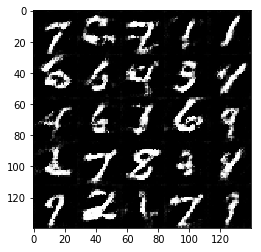

Epochs 2,batches 2310, dis_loss 1.3569724559783936 , gen_loss 0.8247319459915161
Epochs 2,batches 2320, dis_loss 1.4128148555755615 , gen_loss 0.8864191770553589
Epochs 2,batches 2330, dis_loss 1.3389900922775269 , gen_loss 0.8517204523086548
Epochs 2,batches 2340, dis_loss 1.326927900314331 , gen_loss 0.835967481136322
Epochs 2,batches 2350, dis_loss 1.280252456665039 , gen_loss 0.8604118227958679
Epochs 2,batches 2360, dis_loss 1.2701783180236816 , gen_loss 0.7886883020401001
Epochs 2,batches 2370, dis_loss 1.3407690525054932 , gen_loss 0.8068293333053589
Epochs 2,batches 2380, dis_loss 1.3656926155090332 , gen_loss 0.8206738829612732
Epochs 2,batches 2390, dis_loss 1.2832106351852417 , gen_loss 0.8010151982307434
Epochs 2,batches 2400, dis_loss 1.2814072370529175 , gen_loss 0.7770412564277649


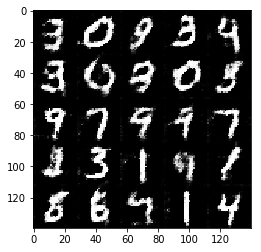

Epochs 2,batches 2410, dis_loss 1.345865249633789 , gen_loss 0.8345186710357666
Epochs 2,batches 2420, dis_loss 1.3445230722427368 , gen_loss 0.8147509098052979
Epochs 2,batches 2430, dis_loss 1.3435370922088623 , gen_loss 0.777783989906311
Epochs 2,batches 2440, dis_loss 1.3746898174285889 , gen_loss 0.8468942642211914
Epochs 2,batches 2450, dis_loss 1.3602796792984009 , gen_loss 0.7446780800819397
Epochs 2,batches 2460, dis_loss 1.4166631698608398 , gen_loss 0.8276433348655701
Epochs 2,batches 2470, dis_loss 1.3368407487869263 , gen_loss 0.7632552981376648
Epochs 2,batches 2480, dis_loss 1.24971604347229 , gen_loss 0.8865295648574829
Epochs 2,batches 2490, dis_loss 1.2767081260681152 , gen_loss 0.903071403503418
Epochs 2,batches 2500, dis_loss 1.470273494720459 , gen_loss 0.7453268766403198


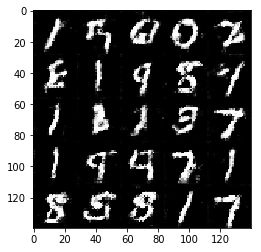

Epochs 2,batches 2510, dis_loss 1.3264503479003906 , gen_loss 0.8232889175415039
Epochs 2,batches 2520, dis_loss 1.3077409267425537 , gen_loss 0.7858151197433472
Epochs 2,batches 2530, dis_loss 1.3524670600891113 , gen_loss 0.9246248006820679
Epochs 2,batches 2540, dis_loss 1.4877355098724365 , gen_loss 0.7560955286026001
Epochs 2,batches 2550, dis_loss 1.3263733386993408 , gen_loss 0.7789475321769714
Epochs 2,batches 2560, dis_loss 1.4443953037261963 , gen_loss 0.7487980127334595
Epochs 2,batches 2570, dis_loss 1.4232490062713623 , gen_loss 0.7498928904533386
Epochs 2,batches 2580, dis_loss 1.4366085529327393 , gen_loss 0.7336148619651794
Epochs 2,batches 2590, dis_loss 1.4175043106079102 , gen_loss 0.7838178277015686
Epochs 2,batches 2600, dis_loss 1.355072259902954 , gen_loss 0.8993703126907349


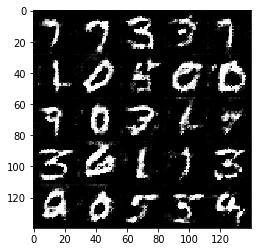

Epochs 2,batches 2610, dis_loss 1.4068257808685303 , gen_loss 0.7594326138496399
Epochs 2,batches 2620, dis_loss 1.3468574285507202 , gen_loss 0.7351891994476318
Epochs 2,batches 2630, dis_loss 1.3023747205734253 , gen_loss 0.78476881980896
Epochs 2,batches 2640, dis_loss 1.3382813930511475 , gen_loss 0.7276476621627808
Epochs 2,batches 2650, dis_loss 1.3767247200012207 , gen_loss 0.8444913029670715
Epochs 2,batches 2660, dis_loss 1.3024077415466309 , gen_loss 0.7776094675064087
Epochs 2,batches 2670, dis_loss 1.2658226490020752 , gen_loss 0.8154983520507812
Epochs 2,batches 2680, dis_loss 1.4194488525390625 , gen_loss 0.8511094450950623
Epochs 2,batches 2690, dis_loss 1.3826957941055298 , gen_loss 0.8546659350395203
Epochs 2,batches 2700, dis_loss 1.3131835460662842 , gen_loss 0.8312240242958069


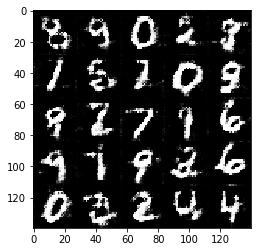

Epochs 2,batches 2710, dis_loss 1.27178955078125 , gen_loss 0.8955663442611694
Epochs 2,batches 2720, dis_loss 1.3431367874145508 , gen_loss 0.7711148858070374
Epochs 2,batches 2730, dis_loss 1.2928049564361572 , gen_loss 0.8690812587738037
Epochs 2,batches 2740, dis_loss 1.325345516204834 , gen_loss 0.8346971869468689
Epochs 2,batches 2750, dis_loss 1.346940279006958 , gen_loss 0.8737413883209229
Epochs 2,batches 2760, dis_loss 1.3089337348937988 , gen_loss 0.873762309551239
Epochs 2,batches 2770, dis_loss 1.2638118267059326 , gen_loss 0.8169134855270386
Epochs 2,batches 2780, dis_loss 1.2237730026245117 , gen_loss 0.8993422389030457
Epochs 2,batches 2790, dis_loss 1.3005428314208984 , gen_loss 0.8041553497314453
Epochs 2,batches 2800, dis_loss 1.3053600788116455 , gen_loss 0.8342602849006653


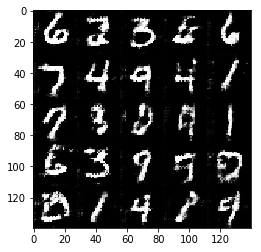

Epochs 2,batches 2810, dis_loss 1.2790672779083252 , gen_loss 0.8897963166236877
Epochs 2,batches 2820, dis_loss 1.3701262474060059 , gen_loss 0.7805930972099304
Epochs 2,batches 2830, dis_loss 1.4078657627105713 , gen_loss 0.8026146292686462
Epochs 2,batches 2840, dis_loss 1.3677446842193604 , gen_loss 0.7717760801315308
Epochs 2,batches 2850, dis_loss 1.2714545726776123 , gen_loss 0.8118592500686646
Epochs 2,batches 2860, dis_loss 1.2394464015960693 , gen_loss 0.7779741883277893
Epochs 2,batches 2870, dis_loss 1.3325989246368408 , gen_loss 0.8535236120223999
Epochs 2,batches 2880, dis_loss 1.420335054397583 , gen_loss 0.7541087865829468
Epochs 2,batches 2890, dis_loss 1.2660753726959229 , gen_loss 0.7771570682525635
Epochs 2,batches 2900, dis_loss 1.2604823112487793 , gen_loss 0.8929678797721863


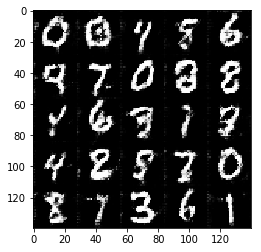

Epochs 2,batches 2910, dis_loss 1.4285664558410645 , gen_loss 0.886169970035553
Epochs 2,batches 2920, dis_loss 1.4245033264160156 , gen_loss 0.836496889591217
Epochs 2,batches 2930, dis_loss 1.239709496498108 , gen_loss 0.8340699672698975
Epochs 2,batches 2940, dis_loss 1.3975861072540283 , gen_loss 0.924221396446228
Epochs 2,batches 2950, dis_loss 1.3260555267333984 , gen_loss 0.8015830516815186
Epochs 2,batches 2960, dis_loss 1.34630286693573 , gen_loss 0.8364372253417969
Epochs 2,batches 2970, dis_loss 1.3511066436767578 , gen_loss 0.7457759976387024
Epochs 2,batches 2980, dis_loss 1.3789000511169434 , gen_loss 0.816143810749054
Epochs 2,batches 2990, dis_loss 1.3801774978637695 , gen_loss 0.7775131464004517
Epochs 2,batches 3000, dis_loss 1.3383204936981201 , gen_loss 0.7347647547721863


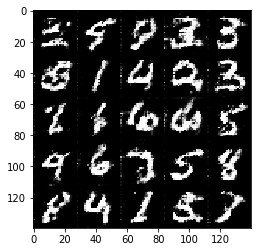

Epochs 2,batches 3010, dis_loss 1.3159077167510986 , gen_loss 0.7677131295204163
Epochs 2,batches 3020, dis_loss 1.346231460571289 , gen_loss 0.7627125978469849
Epochs 2,batches 3030, dis_loss 1.2605140209197998 , gen_loss 0.8727754354476929
Epochs 2,batches 3040, dis_loss 1.3692889213562012 , gen_loss 0.8610011339187622
Epochs 2,batches 3050, dis_loss 1.3035920858383179 , gen_loss 0.8838497400283813
Epochs 2,batches 3060, dis_loss 1.327178955078125 , gen_loss 0.7987837195396423
Epochs 2,batches 3070, dis_loss 1.4248815774917603 , gen_loss 0.8155550360679626
Epochs 2,batches 3080, dis_loss 1.27992582321167 , gen_loss 0.8439724445343018
Epochs 2,batches 3090, dis_loss 1.3150194883346558 , gen_loss 0.8064814805984497
Epochs 2,batches 3100, dis_loss 1.4043188095092773 , gen_loss 0.7537151575088501


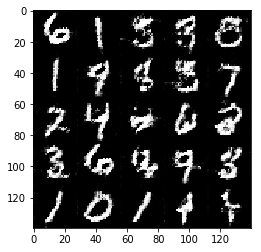

Epochs 2,batches 3110, dis_loss 1.3155248165130615 , gen_loss 0.8237475752830505
Epochs 2,batches 3120, dis_loss 1.3383524417877197 , gen_loss 0.7618287205696106
Epochs 2,batches 3130, dis_loss 1.327286720275879 , gen_loss 0.8560863137245178
Epochs 2,batches 3140, dis_loss 1.3293638229370117 , gen_loss 0.8875052332878113
Epochs 2,batches 3150, dis_loss 1.2900913953781128 , gen_loss 0.887050211429596
Epochs 2,batches 3160, dis_loss 1.4318559169769287 , gen_loss 0.9123932123184204
Epochs 2,batches 3170, dis_loss 1.3117849826812744 , gen_loss 0.9621569514274597
Epochs 2,batches 3180, dis_loss 1.3021209239959717 , gen_loss 0.812976062297821
Epochs 2,batches 3190, dis_loss 1.3056796789169312 , gen_loss 0.8248405456542969
Epochs 2,batches 3200, dis_loss 1.236025094985962 , gen_loss 0.933029055595398


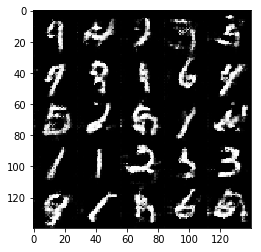

Epochs 2,batches 3210, dis_loss 1.3416954278945923 , gen_loss 0.8197166323661804
Epochs 2,batches 3220, dis_loss 1.267853856086731 , gen_loss 0.7936561703681946
Epochs 2,batches 3230, dis_loss 1.3540281057357788 , gen_loss 0.8371479511260986
Epochs 2,batches 3240, dis_loss 1.3442447185516357 , gen_loss 0.8282000422477722
Epochs 2,batches 3250, dis_loss 1.2556209564208984 , gen_loss 0.8836348652839661
Epochs 2,batches 3260, dis_loss 1.3484035730361938 , gen_loss 0.8915712237358093
Epochs 2,batches 3270, dis_loss 1.2261080741882324 , gen_loss 0.9140903949737549
Epochs 2,batches 3280, dis_loss 1.2801527976989746 , gen_loss 0.8577079176902771
Epochs 2,batches 3290, dis_loss 1.2475337982177734 , gen_loss 0.9265220761299133
Epochs 2,batches 3300, dis_loss 1.3597965240478516 , gen_loss 0.8278566002845764


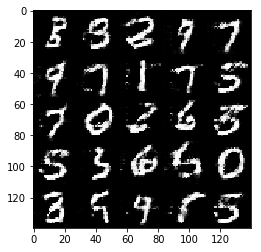

Epochs 2,batches 3310, dis_loss 1.2998430728912354 , gen_loss 0.875799834728241
Epochs 2,batches 3320, dis_loss 1.2842767238616943 , gen_loss 0.8136321902275085
Epochs 2,batches 3330, dis_loss 1.3296866416931152 , gen_loss 0.8455341458320618
Epochs 2,batches 3340, dis_loss 1.334373950958252 , gen_loss 0.7968882918357849
Epochs 2,batches 3350, dis_loss 1.3354662656784058 , gen_loss 0.8497864603996277
Epochs 2,batches 3360, dis_loss 1.2981986999511719 , gen_loss 0.842128336429596
Epochs 2,batches 3370, dis_loss 1.3206950426101685 , gen_loss 0.866235077381134
Epochs 2,batches 3380, dis_loss 1.378995656967163 , gen_loss 0.727344274520874
Epochs 2,batches 3390, dis_loss 1.3521502017974854 , gen_loss 0.9418164491653442
Epochs 2,batches 3400, dis_loss 1.3249483108520508 , gen_loss 0.878111720085144


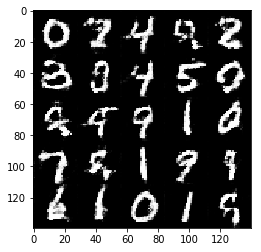

Epochs 2,batches 3410, dis_loss 1.3756847381591797 , gen_loss 0.8720956444740295
Epochs 2,batches 3420, dis_loss 1.2036571502685547 , gen_loss 0.8069176077842712
Epochs 2,batches 3430, dis_loss 1.3965425491333008 , gen_loss 0.8225842118263245
Epochs 2,batches 3440, dis_loss 1.301236867904663 , gen_loss 0.8524145483970642
Epochs 2,batches 3450, dis_loss 1.2760529518127441 , gen_loss 0.849872887134552
Epochs 2,batches 3460, dis_loss 1.3889219760894775 , gen_loss 0.762283980846405
Epochs 2,batches 3470, dis_loss 1.3036460876464844 , gen_loss 0.8461169600486755
Epochs 2,batches 3480, dis_loss 1.2517169713974 , gen_loss 0.8137373328208923
Epochs 2,batches 3490, dis_loss 1.3066174983978271 , gen_loss 0.8176933526992798
Epochs 2,batches 3500, dis_loss 1.4140408039093018 , gen_loss 0.9199880361557007


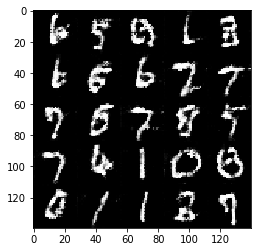

Epochs 2,batches 3510, dis_loss 1.3845901489257812 , gen_loss 0.8291479349136353
Epochs 2,batches 3520, dis_loss 1.3179144859313965 , gen_loss 0.8046547770500183
Epochs 2,batches 3530, dis_loss 1.248927354812622 , gen_loss 0.8602475523948669
Epochs 2,batches 3540, dis_loss 1.3237813711166382 , gen_loss 0.8018203973770142
Epochs 2,batches 3550, dis_loss 1.445194125175476 , gen_loss 0.7508031129837036
Epochs 2,batches 3560, dis_loss 1.4185634851455688 , gen_loss 0.8209988474845886
Epochs 2,batches 3570, dis_loss 1.4670993089675903 , gen_loss 0.9308274388313293
Epochs 2,batches 3580, dis_loss 1.3504948616027832 , gen_loss 0.8378363847732544
Epochs 2,batches 3590, dis_loss 1.388702392578125 , gen_loss 0.9119583964347839
Epochs 2,batches 3600, dis_loss 1.5109455585479736 , gen_loss 0.763511598110199


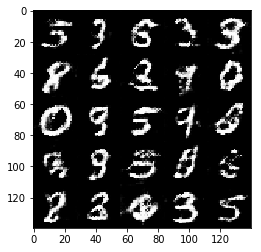

Epochs 2,batches 3610, dis_loss 1.3322468996047974 , gen_loss 0.8412635326385498
Epochs 2,batches 3620, dis_loss 1.2714699506759644 , gen_loss 0.8619387149810791
Epochs 2,batches 3630, dis_loss 1.3711433410644531 , gen_loss 0.8364616632461548
Epochs 2,batches 3640, dis_loss 1.2304821014404297 , gen_loss 0.9692672491073608
Epochs 2,batches 3650, dis_loss 1.4826531410217285 , gen_loss 0.9110676050186157
Epochs 2,batches 3660, dis_loss 1.37659752368927 , gen_loss 0.8054210543632507
Epochs 2,batches 3670, dis_loss 1.3743019104003906 , gen_loss 0.7919502258300781
Epochs 2,batches 3680, dis_loss 1.2589019536972046 , gen_loss 0.8851397037506104
Epochs 2,batches 3690, dis_loss 1.248521327972412 , gen_loss 0.8691990971565247
Epochs 2,batches 3700, dis_loss 1.3197007179260254 , gen_loss 0.9040371179580688


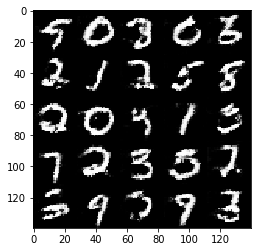

Epochs 2,batches 3710, dis_loss 1.2850556373596191 , gen_loss 0.7896206378936768
Epochs 2,batches 3720, dis_loss 1.2947920560836792 , gen_loss 0.7739827632904053
Epochs 2,batches 3730, dis_loss 1.2283401489257812 , gen_loss 0.9521893262863159
Epochs 2,batches 3740, dis_loss 1.2654991149902344 , gen_loss 0.7943985462188721
Epochs 2,batches 3750, dis_loss 1.21220064163208 , gen_loss 0.8651009798049927
Epochs 2,batches 3760, dis_loss 1.2982933521270752 , gen_loss 0.8077741265296936
Epochs 2,batches 3770, dis_loss 1.2811200618743896 , gen_loss 0.9218212962150574
Epochs 2,batches 3780, dis_loss 1.1627967357635498 , gen_loss 0.8149569034576416
Epochs 2,batches 3790, dis_loss 1.0812147855758667 , gen_loss 1.1455271244049072
Epochs 2,batches 3800, dis_loss 1.3230230808258057 , gen_loss 0.8226594924926758


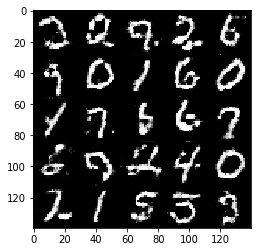

Epochs 2,batches 3810, dis_loss 1.3847368955612183 , gen_loss 0.846703290939331
Epochs 2,batches 3820, dis_loss 1.2790780067443848 , gen_loss 0.8350160121917725
Epochs 2,batches 3830, dis_loss 1.7150826454162598 , gen_loss 0.9111660122871399
Epochs 2,batches 3840, dis_loss 1.2654147148132324 , gen_loss 0.7916650176048279
Epochs 2,batches 3850, dis_loss 1.1631896495819092 , gen_loss 0.9744309782981873
Epochs 2,batches 3860, dis_loss 1.2805125713348389 , gen_loss 0.7930067777633667
Epochs 2,batches 3870, dis_loss 1.1841366291046143 , gen_loss 0.8279326558113098
Epochs 2,batches 3880, dis_loss 1.349910020828247 , gen_loss 0.8115694522857666
Epochs 2,batches 3890, dis_loss 1.3290584087371826 , gen_loss 0.8103542327880859
Epochs 2,batches 3900, dis_loss 1.2693158388137817 , gen_loss 1.0065771341323853


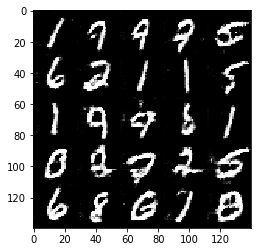

Epochs 2,batches 3910, dis_loss 1.413332462310791 , gen_loss 0.8426611423492432
Epochs 2,batches 3920, dis_loss 1.1378251314163208 , gen_loss 0.7779660820960999
Epochs 2,batches 3930, dis_loss 1.4183080196380615 , gen_loss 0.7861942052841187
Epochs 2,batches 3940, dis_loss 1.2627525329589844 , gen_loss 0.8251582980155945
Epochs 2,batches 3950, dis_loss 1.389833688735962 , gen_loss 0.9421316385269165
Epochs 2,batches 3960, dis_loss 1.4071202278137207 , gen_loss 0.7296995520591736
Epochs 2,batches 3970, dis_loss 1.2330573797225952 , gen_loss 0.8597590327262878
Epochs 2,batches 3980, dis_loss 1.4853582382202148 , gen_loss 0.8618615865707397
Epochs 2,batches 3990, dis_loss 1.414232611656189 , gen_loss 0.8082426190376282
Epochs 2,batches 4000, dis_loss 1.3400927782058716 , gen_loss 0.8984593152999878


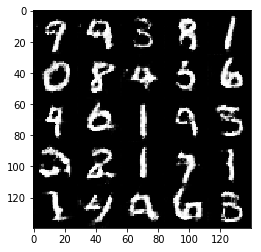

In [88]:
batch_size = 30
z_dim = 100
learning_rate = 0.0001
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

initial output


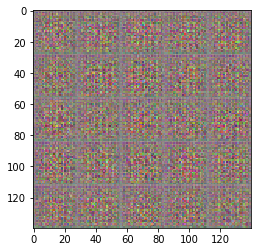

Epochs 1,batches 10, dis_loss 1.8733127117156982 , gen_loss 0.9952267408370972
Epochs 1,batches 20, dis_loss 1.6819356679916382 , gen_loss 1.0355690717697144
Epochs 1,batches 30, dis_loss 1.5889103412628174 , gen_loss 1.0091173648834229
Epochs 1,batches 40, dis_loss 1.5761487483978271 , gen_loss 0.9529696702957153
Epochs 1,batches 50, dis_loss 1.5767490863800049 , gen_loss 0.9320099353790283
Epochs 1,batches 60, dis_loss 1.4939159154891968 , gen_loss 0.9237212538719177
Epochs 1,batches 70, dis_loss 1.6188181638717651 , gen_loss 1.027761459350586
Epochs 1,batches 80, dis_loss 1.516750454902649 , gen_loss 0.9820548295974731
Epochs 1,batches 90, dis_loss 1.3500609397888184 , gen_loss 0.9302082061767578
Epochs 1,batches 100, dis_loss 1.3551948070526123 , gen_loss 1.0240360498428345


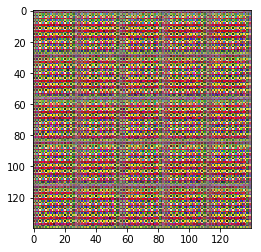

Epochs 1,batches 110, dis_loss 1.3844382762908936 , gen_loss 1.0003635883331299
Epochs 1,batches 120, dis_loss 1.3768054246902466 , gen_loss 1.1752077341079712
Epochs 1,batches 130, dis_loss 1.1742558479309082 , gen_loss 1.2390037775039673
Epochs 1,batches 140, dis_loss 0.9732849597930908 , gen_loss 1.2622802257537842
Epochs 1,batches 150, dis_loss 0.8797926902770996 , gen_loss 1.3996424674987793
Epochs 1,batches 160, dis_loss 1.1702169179916382 , gen_loss 1.446821928024292
Epochs 1,batches 170, dis_loss 0.8783169388771057 , gen_loss 1.5499885082244873
Epochs 1,batches 180, dis_loss 0.9290071725845337 , gen_loss 1.7823644876480103
Epochs 1,batches 190, dis_loss 1.1012194156646729 , gen_loss 1.7166059017181396
Epochs 1,batches 200, dis_loss 0.6723071336746216 , gen_loss 1.7546261548995972


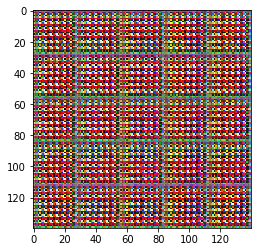

Epochs 1,batches 210, dis_loss 0.6222056150436401 , gen_loss 1.863539218902588
Epochs 1,batches 220, dis_loss 0.8812503218650818 , gen_loss 2.0004820823669434
Epochs 1,batches 230, dis_loss 0.7605168223381042 , gen_loss 2.2396087646484375
Epochs 1,batches 240, dis_loss 0.6752957701683044 , gen_loss 2.184474229812622
Epochs 1,batches 250, dis_loss 0.8128575682640076 , gen_loss 2.1020631790161133
Epochs 1,batches 260, dis_loss 1.1602504253387451 , gen_loss 0.9760106205940247
Epochs 1,batches 270, dis_loss 0.9216527342796326 , gen_loss 1.0959075689315796
Epochs 1,batches 280, dis_loss 1.339829444885254 , gen_loss 1.2321548461914062
Epochs 1,batches 290, dis_loss 0.9055344462394714 , gen_loss 1.879057765007019
Epochs 1,batches 300, dis_loss 1.1328072547912598 , gen_loss 0.877339243888855


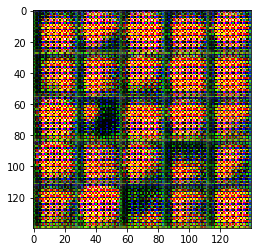

Epochs 1,batches 310, dis_loss 0.804864227771759 , gen_loss 1.5540755987167358
Epochs 1,batches 320, dis_loss 0.8988956212997437 , gen_loss 1.202370047569275
Epochs 1,batches 330, dis_loss 0.7141368985176086 , gen_loss 1.6252906322479248
Epochs 1,batches 340, dis_loss 0.8663177490234375 , gen_loss 1.0863189697265625
Epochs 1,batches 350, dis_loss 0.61238694190979 , gen_loss 1.623106598854065
Epochs 1,batches 360, dis_loss 0.7951916456222534 , gen_loss 1.4139840602874756
Epochs 1,batches 370, dis_loss 0.6775137782096863 , gen_loss 1.655866265296936
Epochs 1,batches 380, dis_loss 0.5957716107368469 , gen_loss 1.8035367727279663
Epochs 1,batches 390, dis_loss 0.8355620503425598 , gen_loss 1.312640905380249
Epochs 1,batches 400, dis_loss 0.6470987796783447 , gen_loss 1.52596116065979


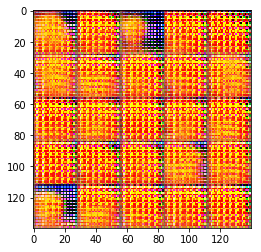

Epochs 1,batches 410, dis_loss 0.7328084111213684 , gen_loss 1.5515676736831665
Epochs 1,batches 420, dis_loss 0.6326234936714172 , gen_loss 1.9127507209777832
Epochs 1,batches 430, dis_loss 0.5351932644844055 , gen_loss 1.9431627988815308
Epochs 1,batches 440, dis_loss 0.6503077745437622 , gen_loss 1.6746500730514526
Epochs 1,batches 450, dis_loss 0.6400566697120667 , gen_loss 1.7543575763702393
Epochs 1,batches 460, dis_loss 0.5707389712333679 , gen_loss 2.1391170024871826
Epochs 1,batches 470, dis_loss 0.4950169324874878 , gen_loss 2.2241556644439697
Epochs 1,batches 480, dis_loss 0.5086997747421265 , gen_loss 1.9623634815216064
Epochs 1,batches 490, dis_loss 0.4920692443847656 , gen_loss 2.28804874420166
Epochs 1,batches 500, dis_loss 0.4575885534286499 , gen_loss 2.2569499015808105


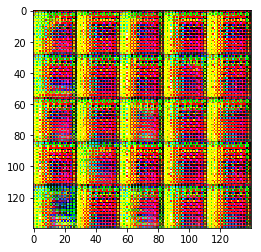

Epochs 1,batches 510, dis_loss 0.4879186749458313 , gen_loss 2.2233800888061523
Epochs 1,batches 520, dis_loss 0.6938968300819397 , gen_loss 2.609779119491577
Epochs 1,batches 530, dis_loss 0.5214346647262573 , gen_loss 1.9436423778533936
Epochs 1,batches 540, dis_loss 0.49153202772140503 , gen_loss 2.0654966831207275
Epochs 1,batches 550, dis_loss 0.776914119720459 , gen_loss 2.3097686767578125
Epochs 1,batches 560, dis_loss 0.46948665380477905 , gen_loss 2.5277533531188965
Epochs 1,batches 570, dis_loss 0.5817384123802185 , gen_loss 2.2083559036254883
Epochs 1,batches 580, dis_loss 0.5220046043395996 , gen_loss 2.2132036685943604
Epochs 1,batches 590, dis_loss 0.654106616973877 , gen_loss 2.351728916168213
Epochs 1,batches 600, dis_loss 0.5137228965759277 , gen_loss 1.9012669324874878


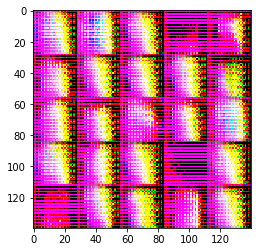

Epochs 1,batches 610, dis_loss 0.5120616555213928 , gen_loss 2.3583836555480957
Epochs 1,batches 620, dis_loss 0.4648490846157074 , gen_loss 2.5016255378723145
Epochs 1,batches 630, dis_loss 0.46784669160842896 , gen_loss 2.416419267654419
Epochs 1,batches 640, dis_loss 0.44651004672050476 , gen_loss 2.4307076930999756
Epochs 1,batches 650, dis_loss 0.610529363155365 , gen_loss 2.2549073696136475
Epochs 1,batches 660, dis_loss 0.5573729872703552 , gen_loss 2.357501268386841
Epochs 1,batches 670, dis_loss 1.39790678024292 , gen_loss 0.6480749249458313
Epochs 1,batches 680, dis_loss 0.6419810056686401 , gen_loss 1.82120943069458
Epochs 1,batches 690, dis_loss 0.649635374546051 , gen_loss 1.7593307495117188
Epochs 1,batches 700, dis_loss 0.4716000556945801 , gen_loss 2.230501890182495


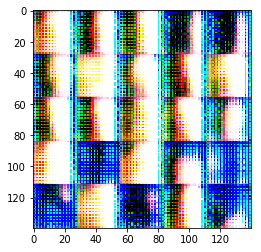

Epochs 1,batches 710, dis_loss 0.46159663796424866 , gen_loss 2.3647453784942627
Epochs 1,batches 720, dis_loss 0.4774031937122345 , gen_loss 2.3808202743530273
Epochs 1,batches 730, dis_loss 0.49055424332618713 , gen_loss 2.4213438034057617
Epochs 1,batches 740, dis_loss 0.4707348048686981 , gen_loss 2.323524236679077
Epochs 1,batches 750, dis_loss 0.5010519027709961 , gen_loss 2.2104649543762207
Epochs 1,batches 760, dis_loss 1.5173368453979492 , gen_loss 0.9862416386604309
Epochs 1,batches 770, dis_loss 0.9257397055625916 , gen_loss 0.9754091501235962
Epochs 1,batches 780, dis_loss 1.7462422847747803 , gen_loss 0.8438761234283447
Epochs 1,batches 790, dis_loss 1.2033332586288452 , gen_loss 0.8883959650993347
Epochs 1,batches 800, dis_loss 0.8328713178634644 , gen_loss 1.2547798156738281


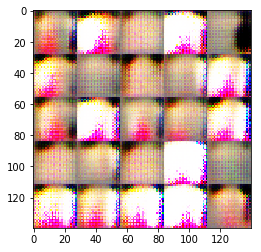

Epochs 1,batches 810, dis_loss 0.7942817211151123 , gen_loss 1.21968412399292
Epochs 1,batches 820, dis_loss 0.5703274011611938 , gen_loss 1.9567400217056274
Epochs 1,batches 830, dis_loss 0.8204734921455383 , gen_loss 1.4892796277999878
Epochs 1,batches 840, dis_loss 0.6460548639297485 , gen_loss 1.792172908782959
Epochs 1,batches 850, dis_loss 1.4338116645812988 , gen_loss 1.8343613147735596
Epochs 1,batches 860, dis_loss 1.333840012550354 , gen_loss 0.6646024584770203
Epochs 1,batches 870, dis_loss 0.9325565099716187 , gen_loss 1.537110686302185
Epochs 1,batches 880, dis_loss 1.6746902465820312 , gen_loss 0.6397930979728699
Epochs 1,batches 890, dis_loss 1.5141818523406982 , gen_loss 1.0514408349990845
Epochs 1,batches 900, dis_loss 1.1792289018630981 , gen_loss 0.7590480446815491


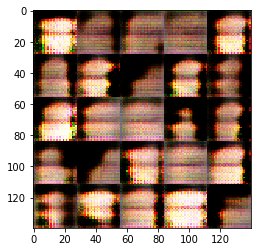

Epochs 1,batches 910, dis_loss 1.0974175930023193 , gen_loss 1.1383445262908936
Epochs 1,batches 920, dis_loss 1.0576672554016113 , gen_loss 0.89822918176651
Epochs 1,batches 930, dis_loss 1.2612603902816772 , gen_loss 0.822756826877594
Epochs 1,batches 940, dis_loss 1.5983158349990845 , gen_loss 0.5916226506233215
Epochs 1,batches 950, dis_loss 1.2097481489181519 , gen_loss 1.294856309890747
Epochs 1,batches 960, dis_loss 1.2334873676300049 , gen_loss 1.5170313119888306
Epochs 1,batches 970, dis_loss 1.787936806678772 , gen_loss 1.5658079385757446
Epochs 1,batches 980, dis_loss 1.1789226531982422 , gen_loss 1.046018362045288
Epochs 1,batches 990, dis_loss 1.325467586517334 , gen_loss 0.8739479184150696
Epochs 1,batches 1000, dis_loss 1.0510354042053223 , gen_loss 1.1959903240203857


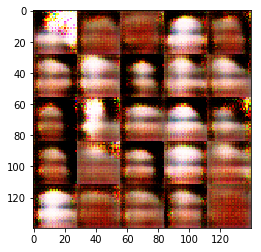

Epochs 1,batches 1010, dis_loss 1.3036999702453613 , gen_loss 1.3700515031814575
Epochs 1,batches 1020, dis_loss 0.7772328853607178 , gen_loss 1.415540337562561
Epochs 1,batches 1030, dis_loss 1.0763418674468994 , gen_loss 1.7178150415420532
Epochs 1,batches 1040, dis_loss 1.4818938970565796 , gen_loss 1.835376501083374
Epochs 1,batches 1050, dis_loss 1.1023375988006592 , gen_loss 0.9291068315505981
Epochs 1,batches 1060, dis_loss 1.1452598571777344 , gen_loss 0.820324718952179
Epochs 1,batches 1070, dis_loss 1.2674977779388428 , gen_loss 1.5263903141021729
Epochs 1,batches 1080, dis_loss 1.2272188663482666 , gen_loss 1.543371319770813
Epochs 1,batches 1090, dis_loss 0.9127480983734131 , gen_loss 1.0708067417144775
Epochs 1,batches 1100, dis_loss 0.9401658773422241 , gen_loss 1.0222090482711792


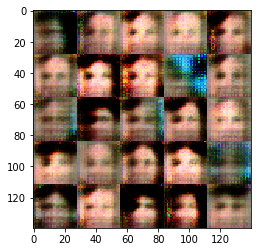

Epochs 1,batches 1110, dis_loss 1.2587993144989014 , gen_loss 0.7614481449127197
Epochs 1,batches 1120, dis_loss 0.6816304922103882 , gen_loss 1.5415633916854858
Epochs 1,batches 1130, dis_loss 1.0919668674468994 , gen_loss 1.2582290172576904
Epochs 1,batches 1140, dis_loss 1.2136452198028564 , gen_loss 1.2046715021133423
Epochs 1,batches 1150, dis_loss 1.4079334735870361 , gen_loss 1.7926156520843506
Epochs 1,batches 1160, dis_loss 1.4060090780258179 , gen_loss 0.6786035895347595
Epochs 1,batches 1170, dis_loss 1.0044423341751099 , gen_loss 1.1378880739212036
Epochs 1,batches 1180, dis_loss 1.436248540878296 , gen_loss 1.0818736553192139
Epochs 1,batches 1190, dis_loss 0.9001827836036682 , gen_loss 1.8185604810714722
Epochs 1,batches 1200, dis_loss 1.5287508964538574 , gen_loss 0.5300607085227966


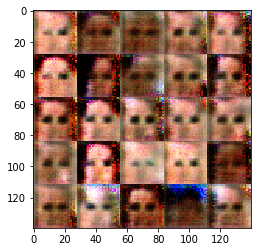

Epochs 1,batches 1210, dis_loss 0.9691367149353027 , gen_loss 1.0982006788253784
Epochs 1,batches 1220, dis_loss 0.9330539107322693 , gen_loss 1.1804262399673462
Epochs 1,batches 1230, dis_loss 0.7336743474006653 , gen_loss 1.2781540155410767
Epochs 1,batches 1240, dis_loss 0.5885368585586548 , gen_loss 1.6461557149887085
Epochs 1,batches 1250, dis_loss 0.8766909241676331 , gen_loss 1.9736424684524536
Epochs 1,batches 1260, dis_loss 0.9633816480636597 , gen_loss 1.0147234201431274
Epochs 1,batches 1270, dis_loss 1.0044875144958496 , gen_loss 1.0935810804367065
Epochs 1,batches 1280, dis_loss 0.797493040561676 , gen_loss 1.423017144203186
Epochs 1,batches 1290, dis_loss 0.9054667949676514 , gen_loss 1.1494526863098145
Epochs 1,batches 1300, dis_loss 1.1534504890441895 , gen_loss 1.563238501548767


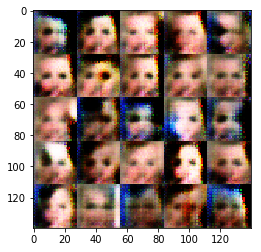

Epochs 1,batches 1310, dis_loss 1.0693304538726807 , gen_loss 1.8979812860488892
Epochs 1,batches 1320, dis_loss 1.0856314897537231 , gen_loss 1.3036917448043823
Epochs 1,batches 1330, dis_loss 0.8546400666236877 , gen_loss 1.2417081594467163
Epochs 1,batches 1340, dis_loss 1.089942455291748 , gen_loss 1.208770751953125
Epochs 1,batches 1350, dis_loss 1.6775710582733154 , gen_loss 1.3486015796661377
Epochs 1,batches 1360, dis_loss 1.0541619062423706 , gen_loss 1.045398235321045
Epochs 1,batches 1370, dis_loss 0.8654149174690247 , gen_loss 1.248241662979126
Epochs 1,batches 1380, dis_loss 1.4955533742904663 , gen_loss 0.4425109028816223
Epochs 1,batches 1390, dis_loss 1.4827325344085693 , gen_loss 0.8675133585929871
Epochs 1,batches 1400, dis_loss 0.9696475267410278 , gen_loss 1.4176191091537476


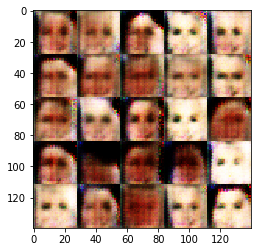

Epochs 1,batches 1410, dis_loss 0.8021718859672546 , gen_loss 1.5926783084869385
Epochs 1,batches 1420, dis_loss 1.0634100437164307 , gen_loss 0.6577187776565552
Epochs 1,batches 1430, dis_loss 0.7168768048286438 , gen_loss 1.4423686265945435
Epochs 1,batches 1440, dis_loss 0.6624393463134766 , gen_loss 1.8678196668624878
Epochs 1,batches 1450, dis_loss 1.236778736114502 , gen_loss 1.9046900272369385
Epochs 1,batches 1460, dis_loss 1.45632004737854 , gen_loss 0.5270584225654602
Epochs 1,batches 1470, dis_loss 1.0304750204086304 , gen_loss 1.4657797813415527
Epochs 1,batches 1480, dis_loss 1.195554256439209 , gen_loss 0.6595404148101807
Epochs 1,batches 1490, dis_loss 1.1881822347640991 , gen_loss 1.828588843345642
Epochs 1,batches 1500, dis_loss 1.4312959909439087 , gen_loss 1.2738546133041382


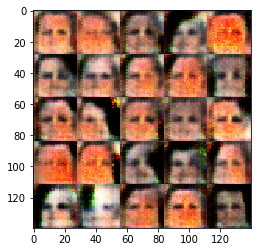

Epochs 1,batches 1510, dis_loss 1.3022637367248535 , gen_loss 0.7996494174003601
Epochs 1,batches 1520, dis_loss 1.0760498046875 , gen_loss 1.627361536026001
Epochs 1,batches 1530, dis_loss 1.040744423866272 , gen_loss 1.561944603919983
Epochs 1,batches 1540, dis_loss 0.6891875267028809 , gen_loss 1.9615846872329712
Epochs 1,batches 1550, dis_loss 1.0076727867126465 , gen_loss 1.0862256288528442
Epochs 1,batches 1560, dis_loss 1.1652098894119263 , gen_loss 1.6699861288070679
Epochs 1,batches 1570, dis_loss 0.8105610609054565 , gen_loss 1.0805327892303467
Epochs 1,batches 1580, dis_loss 0.8598664999008179 , gen_loss 2.0257747173309326
Epochs 1,batches 1590, dis_loss 0.7042850255966187 , gen_loss 1.340516448020935
Epochs 1,batches 1600, dis_loss 0.9101070165634155 , gen_loss 1.0493700504302979


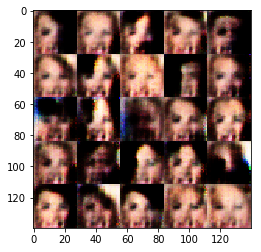

Epochs 1,batches 1610, dis_loss 0.8305923342704773 , gen_loss 1.4545353651046753
Epochs 1,batches 1620, dis_loss 0.7561317086219788 , gen_loss 1.0927128791809082
Epochs 1,batches 1630, dis_loss 1.189353108406067 , gen_loss 2.0870988368988037
Epochs 1,batches 1640, dis_loss 0.7955174446105957 , gen_loss 1.785492181777954
Epochs 1,batches 1650, dis_loss 0.9557181000709534 , gen_loss 1.2169878482818604
Epochs 1,batches 1660, dis_loss 0.6159508228302002 , gen_loss 1.5046902894973755
Epochs 1,batches 1670, dis_loss 0.8479230999946594 , gen_loss 1.8069018125534058
Epochs 1,batches 1680, dis_loss 0.94671630859375 , gen_loss 1.2864935398101807
Epochs 1,batches 1690, dis_loss 1.2935357093811035 , gen_loss 1.641149878501892
Epochs 1,batches 1700, dis_loss 0.7896647453308105 , gen_loss 1.3663538694381714


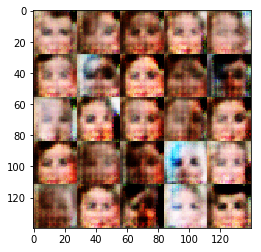

Epochs 1,batches 1710, dis_loss 0.8297152519226074 , gen_loss 1.3738791942596436
Epochs 1,batches 1720, dis_loss 1.154200792312622 , gen_loss 1.00766122341156
Epochs 1,batches 1730, dis_loss 0.7937892079353333 , gen_loss 1.4754000902175903
Epochs 1,batches 1740, dis_loss 0.6416093111038208 , gen_loss 1.608135461807251
Epochs 1,batches 1750, dis_loss 0.9099911451339722 , gen_loss 0.9514788389205933
Epochs 1,batches 1760, dis_loss 0.897753119468689 , gen_loss 1.190134882926941
Epochs 1,batches 1770, dis_loss 0.7518468499183655 , gen_loss 1.6006377935409546
Epochs 1,batches 1780, dis_loss 1.10533607006073 , gen_loss 0.7073735594749451
Epochs 1,batches 1790, dis_loss 1.1475836038589478 , gen_loss 2.7225677967071533
Epochs 1,batches 1800, dis_loss 0.8102485537528992 , gen_loss 1.4123319387435913


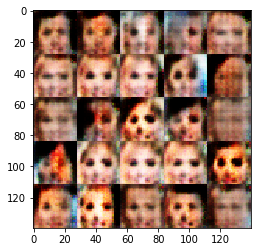

Epochs 1,batches 1810, dis_loss 0.5534996390342712 , gen_loss 2.121516704559326
Epochs 1,batches 1820, dis_loss 0.6430734395980835 , gen_loss 1.6728549003601074
Epochs 1,batches 1830, dis_loss 2.204515218734741 , gen_loss 2.73983097076416
Epochs 1,batches 1840, dis_loss 0.8225428462028503 , gen_loss 1.9822380542755127
Epochs 1,batches 1850, dis_loss 1.0945996046066284 , gen_loss 0.8915058374404907
Epochs 1,batches 1860, dis_loss 0.7489396333694458 , gen_loss 1.7476189136505127
Epochs 1,batches 1870, dis_loss 1.409443736076355 , gen_loss 1.9508894681930542
Epochs 1,batches 1880, dis_loss 0.9188144207000732 , gen_loss 1.1149592399597168
Epochs 1,batches 1890, dis_loss 1.269063949584961 , gen_loss 0.7584916353225708
Epochs 1,batches 1900, dis_loss 1.0336192846298218 , gen_loss 0.887635350227356


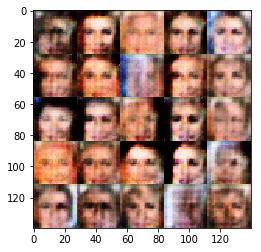

Epochs 1,batches 1910, dis_loss 0.7573517560958862 , gen_loss 1.6517657041549683
Epochs 1,batches 1920, dis_loss 1.0231308937072754 , gen_loss 0.9815673232078552
Epochs 1,batches 1930, dis_loss 1.3202989101409912 , gen_loss 2.6723482608795166
Epochs 1,batches 1940, dis_loss 1.0469179153442383 , gen_loss 1.1025162935256958
Epochs 1,batches 1950, dis_loss 0.7648296356201172 , gen_loss 1.3955702781677246
Epochs 1,batches 1960, dis_loss 0.7232479453086853 , gen_loss 1.3083345890045166
Epochs 1,batches 1970, dis_loss 0.6066497564315796 , gen_loss 1.7447298765182495
Epochs 1,batches 1980, dis_loss 0.7774220108985901 , gen_loss 1.4618384838104248
Epochs 1,batches 1990, dis_loss 0.6729240417480469 , gen_loss 1.868186593055725
Epochs 1,batches 2000, dis_loss 0.7435027360916138 , gen_loss 1.2260102033615112


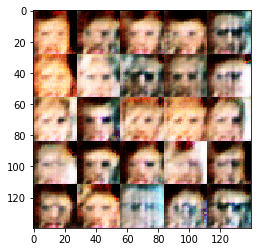

Epochs 1,batches 2010, dis_loss 0.46151816844940186 , gen_loss 2.3849802017211914
Epochs 1,batches 2020, dis_loss 0.5034672021865845 , gen_loss 2.1634867191314697
Epochs 1,batches 2030, dis_loss 0.4645512104034424 , gen_loss 2.2420175075531006
Epochs 1,batches 2040, dis_loss 0.4317447245121002 , gen_loss 2.7836406230926514
Epochs 1,batches 2050, dis_loss 0.4850543439388275 , gen_loss 2.8342676162719727
Epochs 1,batches 2060, dis_loss 0.4258517920970917 , gen_loss 2.4536588191986084
Epochs 1,batches 2070, dis_loss 0.5465099215507507 , gen_loss 2.651304006576538
Epochs 1,batches 2080, dis_loss 0.43391653895378113 , gen_loss 2.5276453495025635
Epochs 1,batches 2090, dis_loss 0.41504183411598206 , gen_loss 3.064164638519287
Epochs 1,batches 2100, dis_loss 0.41223448514938354 , gen_loss 2.9275858402252197


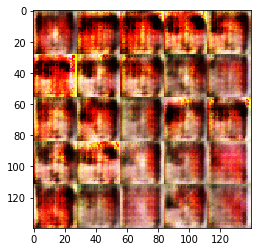

Epochs 1,batches 2110, dis_loss 0.3944472372531891 , gen_loss 3.0976455211639404
Epochs 1,batches 2120, dis_loss 0.7223172187805176 , gen_loss 2.869882345199585
Epochs 1,batches 2130, dis_loss 0.40664392709732056 , gen_loss 2.6949872970581055
Epochs 1,batches 2140, dis_loss 0.4210309088230133 , gen_loss 2.836487293243408
Epochs 1,batches 2150, dis_loss 0.397216796875 , gen_loss 3.0906779766082764
Epochs 1,batches 2160, dis_loss 0.43716517090797424 , gen_loss 2.7869558334350586
Epochs 1,batches 2170, dis_loss 0.3934285044670105 , gen_loss 3.0679266452789307
Epochs 1,batches 2180, dis_loss 0.43125292658805847 , gen_loss 2.6283223628997803
Epochs 1,batches 2190, dis_loss 0.456270694732666 , gen_loss 2.324301242828369
Epochs 1,batches 2200, dis_loss 0.6357801556587219 , gen_loss 1.6938858032226562


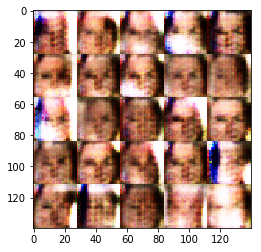

Epochs 1,batches 2210, dis_loss 0.5714408159255981 , gen_loss 1.8897348642349243
Epochs 1,batches 2220, dis_loss 0.44727659225463867 , gen_loss 2.9932448863983154
Epochs 1,batches 2230, dis_loss 0.4234580099582672 , gen_loss 2.9567453861236572
Epochs 1,batches 2240, dis_loss 0.6368231773376465 , gen_loss 2.735576868057251
Epochs 1,batches 2250, dis_loss 0.38082194328308105 , gen_loss 3.2423582077026367
Epochs 1,batches 2260, dis_loss 0.39136913418769836 , gen_loss 3.3124513626098633
Epochs 1,batches 2270, dis_loss 0.4089122414588928 , gen_loss 2.7676539421081543
Epochs 1,batches 2280, dis_loss 0.6481920480728149 , gen_loss 1.6300760507583618
Epochs 1,batches 2290, dis_loss 0.6837062835693359 , gen_loss 1.0723929405212402
Epochs 1,batches 2300, dis_loss 1.1343464851379395 , gen_loss 1.0744163990020752


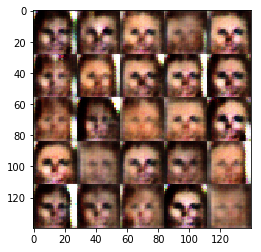

Epochs 1,batches 2310, dis_loss 0.7101259231567383 , gen_loss 1.5605586767196655
Epochs 1,batches 2320, dis_loss 0.5752593278884888 , gen_loss 1.776337742805481
Epochs 1,batches 2330, dis_loss 0.7010601162910461 , gen_loss 3.4058189392089844
Epochs 1,batches 2340, dis_loss 0.4351756274700165 , gen_loss 3.2206456661224365
Epochs 1,batches 2350, dis_loss 1.2076096534729004 , gen_loss 0.7254829406738281
Epochs 1,batches 2360, dis_loss 0.4961143136024475 , gen_loss 2.32139253616333
Epochs 1,batches 2370, dis_loss 0.4296872019767761 , gen_loss 2.5263845920562744
Epochs 1,batches 2380, dis_loss 0.4589974582195282 , gen_loss 2.546071767807007
Epochs 1,batches 2390, dis_loss 0.5160850286483765 , gen_loss 2.668240547180176
Epochs 1,batches 2400, dis_loss 0.7980911731719971 , gen_loss 1.4663134813308716


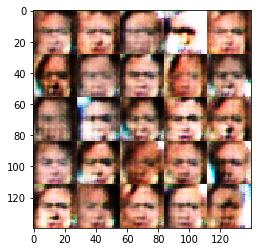

Epochs 1,batches 2410, dis_loss 0.4206739068031311 , gen_loss 3.0256011486053467
Epochs 1,batches 2420, dis_loss 0.5493208765983582 , gen_loss 2.6432042121887207
Epochs 1,batches 2430, dis_loss 0.6327309012413025 , gen_loss 1.6284785270690918
Epochs 1,batches 2440, dis_loss 0.524142324924469 , gen_loss 1.9633489847183228
Epochs 1,batches 2450, dis_loss 0.8120061755180359 , gen_loss 2.463036060333252
Epochs 1,batches 2460, dis_loss 0.5977742075920105 , gen_loss 2.3532943725585938
Epochs 1,batches 2470, dis_loss 0.8650357723236084 , gen_loss 1.2726305723190308
Epochs 1,batches 2480, dis_loss 0.46135058999061584 , gen_loss 2.678814172744751
Epochs 1,batches 2490, dis_loss 0.9264986515045166 , gen_loss 2.284419298171997
Epochs 1,batches 2500, dis_loss 1.5528316497802734 , gen_loss 0.4060288071632385


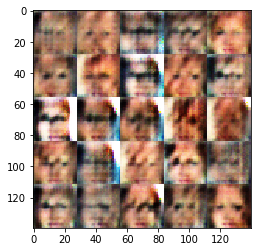

Epochs 1,batches 2510, dis_loss 0.4829096496105194 , gen_loss 3.821594715118408
Epochs 1,batches 2520, dis_loss 0.4364624619483948 , gen_loss 2.850698947906494
Epochs 1,batches 2530, dis_loss 0.42596346139907837 , gen_loss 2.82769513130188
Epochs 1,batches 2540, dis_loss 0.5963082909584045 , gen_loss 1.4338864088058472
Epochs 1,batches 2550, dis_loss 0.49354690313339233 , gen_loss 2.828935146331787
Epochs 1,batches 2560, dis_loss 0.3910161256790161 , gen_loss 3.12510085105896
Epochs 1,batches 2570, dis_loss 0.47515904903411865 , gen_loss 2.1328699588775635
Epochs 1,batches 2580, dis_loss 2.5071768760681152 , gen_loss 3.947021722793579
Epochs 1,batches 2590, dis_loss 0.4729190170764923 , gen_loss 3.3206045627593994
Epochs 1,batches 2600, dis_loss 1.0461668968200684 , gen_loss 1.6202857494354248


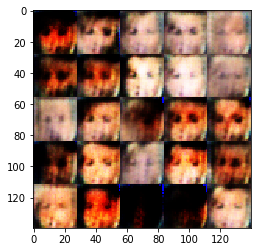

Epochs 1,batches 2610, dis_loss 1.3343757390975952 , gen_loss 1.2337476015090942
Epochs 1,batches 2620, dis_loss 1.1848511695861816 , gen_loss 0.9266213178634644
Epochs 1,batches 2630, dis_loss 0.9121976494789124 , gen_loss 2.4488260746002197
Epochs 1,batches 2640, dis_loss 0.7468531131744385 , gen_loss 2.315716505050659
Epochs 1,batches 2650, dis_loss 1.0140321254730225 , gen_loss 2.4251866340637207
Epochs 1,batches 2660, dis_loss 0.8817721605300903 , gen_loss 1.0239465236663818
Epochs 1,batches 2670, dis_loss 1.2646682262420654 , gen_loss 2.0800116062164307
Epochs 1,batches 2680, dis_loss 0.7728438973426819 , gen_loss 2.0224387645721436
Epochs 1,batches 2690, dis_loss 0.6449594497680664 , gen_loss 1.7284729480743408
Epochs 1,batches 2700, dis_loss 0.7793545722961426 , gen_loss 1.0867207050323486


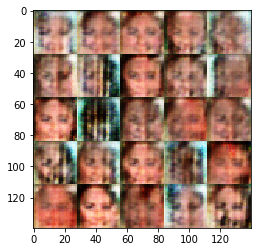

Epochs 1,batches 2710, dis_loss 0.548557460308075 , gen_loss 2.1252012252807617
Epochs 1,batches 2720, dis_loss 0.7234930992126465 , gen_loss 2.005209445953369
Epochs 1,batches 2730, dis_loss 0.9908770322799683 , gen_loss 0.9723525643348694
Epochs 1,batches 2740, dis_loss 0.54213947057724 , gen_loss 2.1844091415405273
Epochs 1,batches 2750, dis_loss 0.8503135442733765 , gen_loss 1.5345219373703003
Epochs 1,batches 2760, dis_loss 0.48516952991485596 , gen_loss 2.3355491161346436
Epochs 1,batches 2770, dis_loss 1.162775993347168 , gen_loss 0.9923507571220398
Epochs 1,batches 2780, dis_loss 1.4704029560089111 , gen_loss 2.7490224838256836
Epochs 1,batches 2790, dis_loss 1.0252633094787598 , gen_loss 1.1755512952804565
Epochs 1,batches 2800, dis_loss 0.5217325687408447 , gen_loss 2.2845699787139893


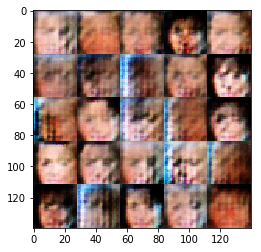

Epochs 1,batches 2810, dis_loss 0.6159295439720154 , gen_loss 1.54486083984375
Epochs 1,batches 2820, dis_loss 0.8540573120117188 , gen_loss 1.4913448095321655
Epochs 1,batches 2830, dis_loss 0.540154218673706 , gen_loss 1.8241273164749146
Epochs 1,batches 2840, dis_loss 1.1423447132110596 , gen_loss 1.147160291671753
Epochs 1,batches 2850, dis_loss 0.893175482749939 , gen_loss 0.8957246541976929
Epochs 1,batches 2860, dis_loss 0.8179782629013062 , gen_loss 1.6938170194625854
Epochs 1,batches 2870, dis_loss 1.3561890125274658 , gen_loss 0.5207262635231018
Epochs 1,batches 2880, dis_loss 0.5789781808853149 , gen_loss 1.810364007949829
Epochs 1,batches 2890, dis_loss 0.5055645108222961 , gen_loss 2.290698766708374
Epochs 1,batches 2900, dis_loss 0.8615499138832092 , gen_loss 1.1020344495773315


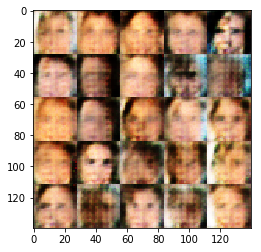

Epochs 1,batches 2910, dis_loss 0.7293170094490051 , gen_loss 2.0657806396484375
Epochs 1,batches 2920, dis_loss 0.7917100191116333 , gen_loss 2.0010666847229004
Epochs 1,batches 2930, dis_loss 0.6036492586135864 , gen_loss 2.1422340869903564
Epochs 1,batches 2940, dis_loss 0.630770742893219 , gen_loss 2.191953420639038
Epochs 1,batches 2950, dis_loss 0.8068089485168457 , gen_loss 2.209974765777588
Epochs 1,batches 2960, dis_loss 1.6497200727462769 , gen_loss 3.599656581878662
Epochs 1,batches 2970, dis_loss 0.9090515375137329 , gen_loss 1.2499719858169556
Epochs 1,batches 2980, dis_loss 0.776344895362854 , gen_loss 2.587580442428589
Epochs 1,batches 2990, dis_loss 1.154693841934204 , gen_loss 1.1209896802902222
Epochs 1,batches 3000, dis_loss 1.6573201417922974 , gen_loss 3.014899253845215


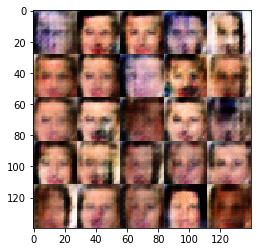

Epochs 1,batches 3010, dis_loss 0.5806194543838501 , gen_loss 1.9803794622421265
Epochs 1,batches 3020, dis_loss 2.401832342147827 , gen_loss 0.3505919873714447
Epochs 1,batches 3030, dis_loss 0.6141422390937805 , gen_loss 1.625603199005127
Epochs 1,batches 3040, dis_loss 0.8310116529464722 , gen_loss 1.9816474914550781
Epochs 1,batches 3050, dis_loss 1.2047418355941772 , gen_loss 0.6014818549156189
Epochs 1,batches 3060, dis_loss 0.7428284883499146 , gen_loss 2.0359926223754883
Epochs 1,batches 3070, dis_loss 0.9158340692520142 , gen_loss 0.9671870470046997
Epochs 1,batches 3080, dis_loss 0.6909612417221069 , gen_loss 1.9702346324920654
Epochs 1,batches 3090, dis_loss 0.6046111583709717 , gen_loss 1.5960357189178467
Epochs 1,batches 3100, dis_loss 0.5416865348815918 , gen_loss 2.0003902912139893


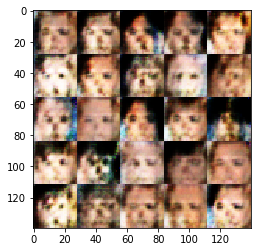

Epochs 1,batches 3110, dis_loss 1.5874314308166504 , gen_loss 1.2509891986846924
Epochs 1,batches 3120, dis_loss 0.6366313099861145 , gen_loss 1.8692771196365356
Epochs 1,batches 3130, dis_loss 1.5197315216064453 , gen_loss 0.711449384689331
Epochs 1,batches 3140, dis_loss 0.9936062693595886 , gen_loss 1.2406553030014038
Epochs 1,batches 3150, dis_loss 0.6261557936668396 , gen_loss 2.428091526031494
Epochs 1,batches 3160, dis_loss 1.264704942703247 , gen_loss 1.0442734956741333
Epochs 1,batches 3170, dis_loss 1.183502197265625 , gen_loss 0.7377738952636719
Epochs 1,batches 3180, dis_loss 0.6426980495452881 , gen_loss 2.2145376205444336
Epochs 1,batches 3190, dis_loss 1.0366734266281128 , gen_loss 3.093292713165283
Epochs 1,batches 3200, dis_loss 0.5317192673683167 , gen_loss 2.023737907409668


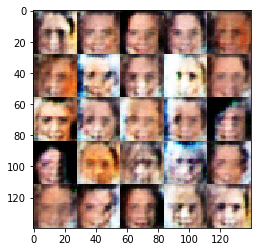

Epochs 1,batches 3210, dis_loss 0.7197843194007874 , gen_loss 2.018162727355957
Epochs 1,batches 3220, dis_loss 0.6305134296417236 , gen_loss 1.438751220703125
Epochs 1,batches 3230, dis_loss 0.5489434003829956 , gen_loss 2.164515256881714
Epochs 1,batches 3240, dis_loss 0.5140758156776428 , gen_loss 2.432847499847412
Epochs 1,batches 3250, dis_loss 0.6156272292137146 , gen_loss 1.6279798746109009
Epochs 1,batches 3260, dis_loss 0.44489169120788574 , gen_loss 2.7374353408813477
Epochs 1,batches 3270, dis_loss 0.467592716217041 , gen_loss 2.494335889816284
Epochs 1,batches 3280, dis_loss 2.3242554664611816 , gen_loss 0.300027996301651
Epochs 1,batches 3290, dis_loss 0.6671245098114014 , gen_loss 1.3374923467636108
Epochs 1,batches 3300, dis_loss 0.8289961814880371 , gen_loss 1.6601976156234741


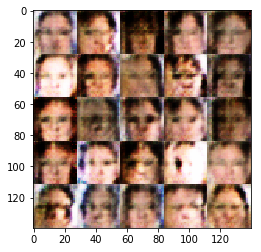

Epochs 1,batches 3310, dis_loss 0.6111032962799072 , gen_loss 2.251513719558716
Epochs 1,batches 3320, dis_loss 0.4899977147579193 , gen_loss 2.899479627609253
Epochs 1,batches 3330, dis_loss 0.6779705286026001 , gen_loss 1.6142903566360474
Epochs 1,batches 3340, dis_loss 0.6001043915748596 , gen_loss 2.4659886360168457
Epochs 1,batches 3350, dis_loss 0.8694992065429688 , gen_loss 1.7247774600982666
Epochs 1,batches 3360, dis_loss 0.5733274817466736 , gen_loss 1.65949285030365
Epochs 1,batches 3370, dis_loss 1.2187690734863281 , gen_loss 0.6857205629348755


In [92]:
batch_size = 60
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.